In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (cluster_utils,
                                            portfolio_utils,
                                            lstm)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '1995-01-01'
date_end = '2010-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 30
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,ACY,1999-09-20 05:00:00,7.250000
1,AA,1999-09-20 05:00:00,97.968753
2,ABT,1999-09-20 05:00:00,20.575147
3,ABM,1999-09-20 05:00:00,11.062500
4,AB,1999-09-20 05:00:00,27.000000


### Clean data

In [3]:
def normalize(df, column='open', window_size=1000):
    df['open_min'] = df[column].rolling(window_size).min()
    df['open_max'] = df[column].rolling(window_size).max()
    df[column] = ((df[column] - df['open_min']) / (df['open_max'] - df['open_min']))
    return df

In [4]:
df['target'] = df['open']
df['open_min'], df['open_max'] = 0, 0

df = df.groupby('symbol').apply(normalize)
df = df[df['open'].notnull()]

In [5]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

In [6]:
def sequence_data(df, column='open', length=100):
    dfs = []
    for offset in range(1, length, 1):
        df = df.join(df[column].shift(offset), rsuffix='_' + str(abs(offset)))
    return df

train_test = df.groupby('symbol').apply(sequence_data)


train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(18150, 123)


,symbol,market_datetime,open,target,open_min,open_max,symbol_A,symbol_AA,symbol_AAP,symbol_AAU,...,open_90,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99
12236,ABT,2004-02-03 06:00:00,0.496197,20.910091,14.354754,27.565912,0,0,0,0,...,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950,0.486001
12238,ABM,2004-02-03 06:00:00,0.817239,17.820000,10.531250,19.450000,0,0,0,0,...,0.511668,0.488464,0.514832,0.530653,0.525379,0.557020,0.547528,0.509558,0.530653,0.514832
12241,ABEV,2004-02-03 06:00:00,0.774504,0.978800,0.432000,1.138000,0,0,0,0,...,0.611898,0.640227,0.669122,0.682720,0.637394,0.651558,0.661756,0.657224,0.684419,0.708215
12242,AB,2004-02-03 06:00:00,0.412857,37.950000,23.500000,58.500000,0,0,0,0,...,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143,0.302286
12243,AA,2004-02-03 06:00:00,0.574561,101.160000,54.000000,136.080000,0,1,0,0,...,0.354532,0.357091,0.362939,0.390351,0.365497,0.364035,0.381944,0.417763,0.374635,0.380117
12249,ABC,2004-02-03 06:00:00,0.620840,13.840000,3.078125,20.412500,0,0,0,0,...,0.617551,0.610050,0.606511,0.598018,0.644020,0.658882,0.672328,0.676999,0.666384,0.670913
12252,ABT,2004-02-04 06:00:00,0.516117,21.173262,14.354754,27.565912,0,0,0,0,...,0.432520,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950
12254,ABM,2004-02-04 06:00:00,0.825088,17.890000,10.531250,19.450000,0,0,0,0,...,0.473698,0.511668,0.488464,0.514832,0.530653,0.525379,0.557020,0.547528,0.509558,0.530653
12255,ABEV,2004-02-04 06:00:00,0.773371,0.978000,0.432000,1.138000,0,0,0,0,...,0.592635,0.611898,0.640227,0.669122,0.682720,0.637394,0.651558,0.661756,0.657224,0.684419
12256,AB,2004-02-04 06:00:00,0.410000,37.850000,23.500000,58.500000,0,0,0,0,...,0.347143,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143


### Train lstm

In [19]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'target']

data_size = int(round(len(train_test)/2, -2))

train = train_test.head(data_size)
test = train_test.tail(int(data_size/2))
# test = train_test.tail(data_size)

Batch 1, Epoch 0, Loss 6542.201171875
Batch 1, Epoch 50, Loss 779.7379150390625
Batch 1, Epoch 100, Loss 631.5935668945312
Batch 1, Epoch 150, Loss 444.81298828125
Batch 1, Epoch 200, Loss 357.2021789550781
Batch 1, Epoch 250, Loss 309.6832275390625
Batch 1, Epoch 300, Loss 279.5003967285156
Batch 1, Epoch 350, Loss 261.0885009765625
Batch 1, Epoch 400, Loss 245.63479614257812
Batch 1, Epoch 450, Loss 236.02101135253906


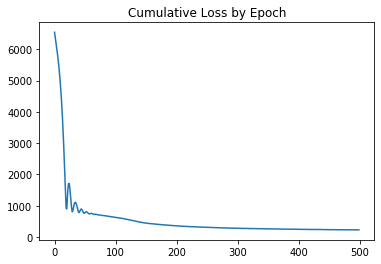

In [20]:
model = lstm.TorchLSTM(
    train_x=train.drop(cols_to_ignore, axis=1),
    train_y=train['open'],
    test_x=test.drop(cols_to_ignore, axis=1),
    test_y=test['open'],
    n_layers=2,
    n_training_batches=1,
    n_epochs=100,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=6
)

model.fit()
# model = nn.DataParallel(model, device_ids=[1, 0])
# model.module.fit()
prediction = model.prediction_df

In [21]:
res = test[cols_to_ignore].join(prediction)
res.head()

,symbol,market_datetime,open,open_min,open_max,target,symbol_A,symbol_AA,symbol_AAP,symbol_AAU,...,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99,prediction
33506,ACN,2008-11-10 06:00:00,0.427865,21.00,43.25,30.52,0,0,0,0,...,0.870562,0.846292,0.912809,0.855730,0.806292,0.817978,0.806292,0.829663,0.828764,0.474947
33505,ABM,2008-11-10 06:00:00,0.167956,13.10,31.20,16.14,0,0,0,0,...,0.401329,0.384053,0.351495,0.438538,0.460465,0.491030,0.487708,0.508306,0.490365,0.189458
33511,ABB,2008-11-10 06:00:00,0.272792,5.34,33.31,12.97,0,0,0,0,...,0.813380,0.796831,0.825704,0.827817,0.827465,0.833099,0.878873,0.908451,0.908451,0.288433
33540,ABB,2008-11-11 06:00:00,0.223454,5.34,33.31,11.59,0,0,0,0,...,0.790845,0.813380,0.796831,0.825704,0.827817,0.827465,0.833099,0.878873,0.908451,0.294719
33539,ACY,2008-11-11 06:00:00,0.418696,2.10,25.10,11.73,0,0,0,0,...,0.473478,0.605652,0.701304,0.661304,0.587391,0.548261,0.484783,0.467826,0.391304,0.408570


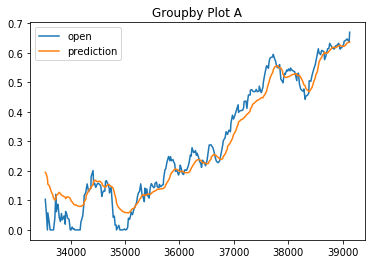

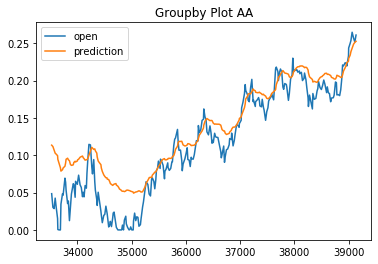

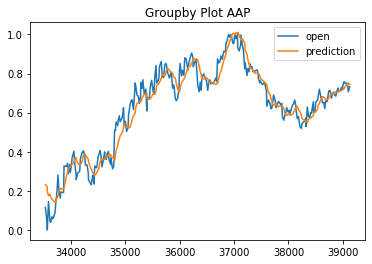

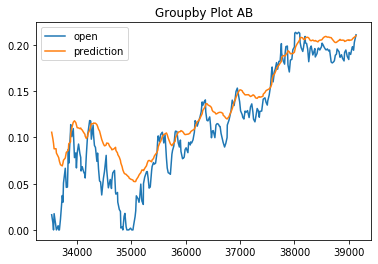

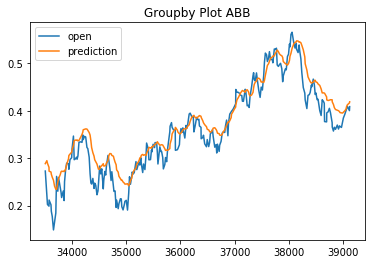

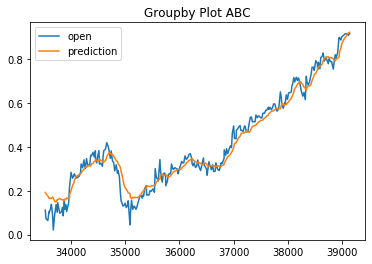

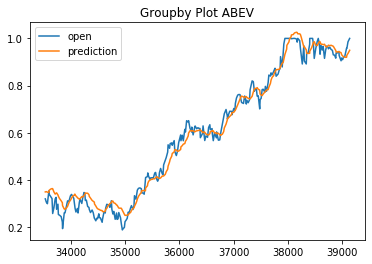

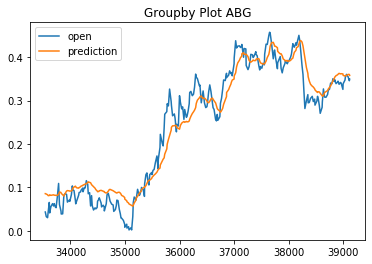

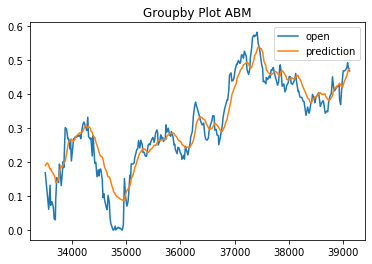

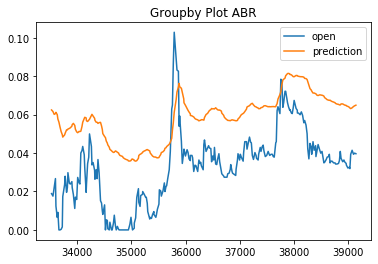

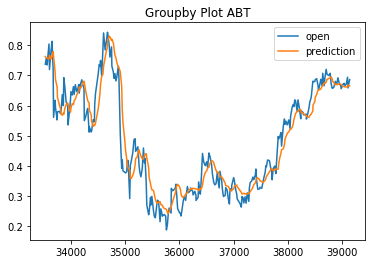

In [22]:
cluster_utils.plot_groupby(res, 'symbol', lines=['open', 'prediction'])